# How much difference does each Epoch make?

## TODO:
- create map of 13 test sites
- schematic of EALSTM
- schematic of calibration/validaation strategy
- table with performance metrics of 13 catchments
- model performance stratified by static variables
- EDIT manuscript

In [11]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jovyan/ml_drought


In [123]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 150

In [13]:
data_dir = Path('data/')

assert data_dir.exists()

In [14]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Read in the data

In [15]:
EXPERIMENT =        'one_timestep_forecast' # '2020_04_23:190425_one_timestep_forecast' 
TRUE_EXPERIMENT =   'one_timestep_forecast'
TARGET_VAR =        'discharge_spec'
STATIC_DATA_FILE =  'data.nc' # '2020_04_23:112630_data.nc_'
DYNAMIC_DATA_FILE = 'data.nc'
N_EPOCHS = 100

assert (data_dir / f"models/{EXPERIMENT}").exists()
assert (data_dir / f"features/{TRUE_EXPERIMENT}").exists()

In [16]:
# read in the training data
ds = xr.open_dataset(Path(f'data/features/{TRUE_EXPERIMENT}/{DYNAMIC_DATA_FILE}'))

# static_ds = xr.open_dataset(Path(f'data/features/static/data.nc'))
all_static = xr.open_dataset(Path(f'data/interim/static/data.nc'))
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

ds['station_id'] = ds['station_id'].astype(int)

In [17]:
ds

<xarray.Dataset>
Dimensions:              (station_id: 671, time: 16436)
Coordinates:
  * station_id           (station_id) int64 1001 2001 2002 ... 106001 107001
  * time                 (time) datetime64[ns] 1970-10-01 ... 2015-09-30
Data variables:
    precipitation        (time, station_id) float64 ...
    discharge_spec       (time, station_id) float64 ...
    peti                 (time, station_id) float64 ...
    target_var_original  (time, station_id) float64 ...

In [18]:
static

<xarray.Dataset>
Dimensions:                       (station_id: 671)
Coordinates:
  * station_id                    (station_id) int64 1001 2001 ... 106001 107001
Data variables:
    inter_high_perc               (station_id) float64 ...
    inter_mod_perc                (station_id) float64 ...
    inter_low_perc                (station_id) float64 ...
    frac_high_perc                (station_id) float64 ...
    frac_mod_perc                 (station_id) float64 ...
    frac_low_perc                 (station_id) float64 ...
    no_gw_perc                    (station_id) float64 ...
    low_nsig_perc                 (station_id) float64 ...
    nsig_low_perc                 (station_id) float64 ...
    gauge_name                    (station_id) object ...
    gauge_lat                     (station_id) float64 ...
    gauge_lon                     (station_id) float64 ...
    gauge_easting                 (station_id) int64 ...
    gauge_northing                (station_id) int64 ...
    gauge_elev                    (station_id) float64 ...
    area                          (station_id) float64 ...
    dpsbar                        (station_id) float64 ...
    elev_mean                     (station_id) float64 ...
    elev_min                      (station_id) float64 ...
    elev_10                       (station_id) float64 ...
    elev_50                       (station_id) float64 ...
    elev_90                       (station_id) float64 ...
    elev_max                      (station_id) float64 ...
    sand_perc                     (station_id) float64 ...
    sand_perc_missing             (station_id) float64 ...
    silt_perc                     (station_id) float64 ...
    silt_perc_missing             (station_id) float64 ...
    clay_perc                     (station_id) float64 ...
    clay_perc_missing             (station_id) float64 ...
    organic_perc                  (station_id) float64 ...
    organic_perc_missing          (station_id) float64 ...
    bulkdens                      (station_id) float64 ...
    bulkdens_missing              (station_id) float64 ...
    bulkdens_5                    (station_id) float64 ...
    bulkdens_50                   (station_id) float64 ...
    bulkdens_95                   (station_id) float64 ...
    tawc                          (station_id) float64 ...
    tawc_missing                  (station_id) float64 ...
    tawc_5                        (station_id) float64 ...
    tawc_50                       (station_id) float64 ...
    tawc_95                       (station_id) float64 ...
    porosity_cosby                (station_id) float64 ...
    porosity_cosby_missing        (station_id) float64 ...
    porosity_cosby_5              (station_id) float64 ...
    porosity_cosby_50             (station_id) float64 ...
    porosity_cosby_95             (station_id) float64 ...
    porosity_hypres               (station_id) float64 ...
    porosity_hypres_missing       (station_id) float64 ...
    porosity_hypres_5             (station_id) float64 ...
    porosity_hypres_50            (station_id) float64 ...
    porosity_hypres_95            (station_id) float64 ...
    conductivity_cosby            (station_id) float64 ...
    conductivity_cosby_missing    (station_id) float64 ...
    conductivity_cosby_5          (station_id) float64 ...
    conductivity_cosby_50         (station_id) float64 ...
    conductivity_cosby_95         (station_id) float64 ...
    conductivity_hypres           (station_id) float64 ...
    conductivity_hypres_missing   (station_id) float64 ...
    conductivity_hypres_5         (station_id) float64 ...
    conductivity_hypres_50        (station_id) float64 ...
    conductivity_hypres_95        (station_id) float64 ...
    root_depth                    (station_id) float64 ...
    root_depth_missing            (station_id) float64 ...
    root_depth_5                  (station_id) float64 ...
    root_depth_50                 (station_id) flo

# Read Gcloud Model results

In [19]:
print([d.name for d in (data_dir/'gcloud').iterdir()])
print([d.name for d in (data_dir/'gcloud').glob('*/*.csv')])

['lstm20', 'lstm_0807_2105', 'ealstm20']
['results_lstm_0807_2105.csv', 'results_ealstm_0907_0401.csv']


In [266]:
df = pd.read_csv(data_dir / "gcloud/all_lstm_0807_2105_results.csv")
df = df[
    ["station_id", "time", "obs"] + sorted(
        [c for c in df.columns if "_E" in c], 
        key=lambda x: int(x.split("_")[-1].replace("E", ""))
    )]
df["time"] = pd.to_datetime(df["time"])
df.head()

,station_id,time,obs,sim_E1,sim_E2,sim_E3,sim_E4,sim_E5,sim_E6,sim_E7,...,sim_E21,sim_E22,sim_E23,sim_E24,sim_E25,sim_E26,sim_E27,sim_E28,sim_E29,sim_E30
0,1001,2010-01-01,0.67,5.805416,5.433262,4.622324,5.533156,5.590217,5.951924,5.707610,...,5.577086,5.238941,5.316413,5.430680,5.461871,5.626487,5.445674,5.572144,5.526667,5.390245
1,1001,2010-01-02,0.73,3.811909,3.620997,2.911469,3.280161,3.480207,3.483495,3.373284,...,3.168868,2.928456,3.037929,3.205674,2.952495,3.259089,3.117439,3.194511,3.253776,3.119981
2,1001,2010-01-03,0.69,2.292167,2.123370,1.635701,1.600605,1.899970,1.697322,1.736790,...,1.701269,1.589922,1.634069,1.747492,1.586121,1.747422,1.680538,1.685478,1.785696,1.677661
3,1001,2010-01-04,0.77,4.087152,3.782193,2.887260,3.133044,3.186318,3.095372,2.963166,...,2.790964,2.547786,2.600357,2.734153,2.632607,2.757543,2.670699,2.694006,2.792865,2.671041
4,1001,2010-01-05,0.81,3.920176,3.697501,2.891813,3.290477,3.350772,3.381227,3.208832,...,3.139927,2.891932,2.955062,3.151455,2.923638,3.155218,2.995046,3.063428,3.138366,3.035645


In [267]:
epoch_ds = df.set_index(["station_id", "time"]).to_xarray()

# Hydrographs

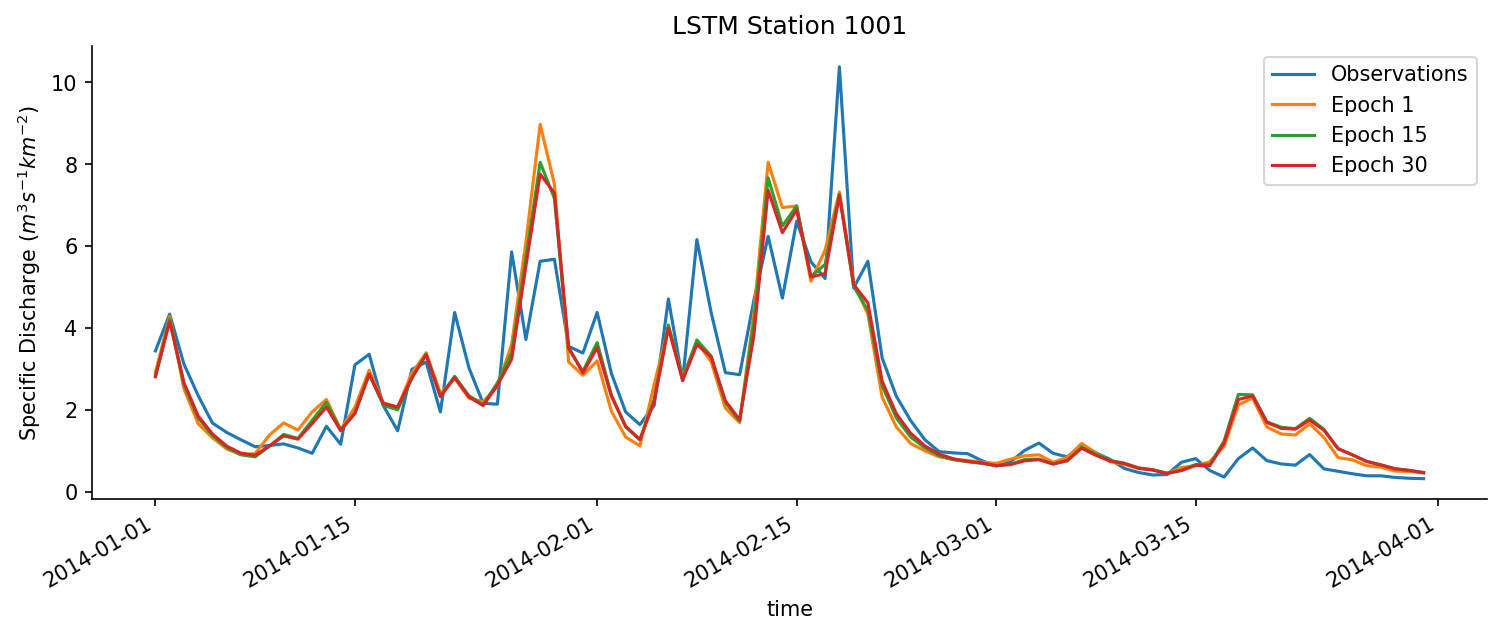

In [379]:
fig, ax = plt.subplots(figsize=(12, 4))
subset = epoch_ds.sel(time=slice("2014-01", "2014-03"))

subset.isel(station_id=0)["obs"].plot(ax=ax, label="Observations")
subset.isel(station_id=0)["sim_E1"].plot(ax=ax, label="Epoch 1")
subset.isel(station_id=0)["sim_E15"].plot(ax=ax, label="Epoch 15")
subset.isel(station_id=0)["sim_E30"].plot(ax=ax, label="Epoch 30")
ax.set_ylabel("Specific Discharge ($m^3 s^{-1} km^{-2}$)")
ax.set_title(f"LSTM Station {lstm_preds.isel(station_id=0).station_id.values}")
plt.legend()
sns.despine()

# Performance on Extremes

# Error Metrics

In [126]:
from src.analysis.evaluation import spatial_rmse, spatial_r2, spatial_nse
from src.analysis.evaluation import temporal_rmse, temporal_r2, temporal_nse
from src.analysis.evaluation import _nse_func, _rmse_func, _r2_func

In [275]:
def error_func(preds_xr: xr.Dataset, error_str: str, epoch: Optional[int] = None) -> pd.DataFrame:
    lookup = {
        "nse": _nse_func,
        "rmse": _rmse_func,
        "r2": _r2_func,
    }
    
    if epoch is None:
        simulated_col = "sim"
    else:
        simulated_col = f"sim_E{epoch}"
    
    error_func = lookup[error_str]
    
    df = preds_xr.to_dataframe()
    df = df.dropna(how='any')
    df = df.reset_index().set_index("time")

    station_ids = df["station_id"].unique()
    errors = []
    for station_id in station_ids:
        d = df.loc[df["station_id"] == station_id]
        if error_str == "rmse":
            _error_calc = error_func(d["obs"].values, d[simulated_col].values, n_instances=d.size)
        else:
            _error_calc = error_func(d["obs"].values, d[simulated_col].values)
        errors.append(_error_calc)

    error = pd.DataFrame({"station_id": station_ids, f"{error_str}_{epoch:03}": errors})
    
    return error

In [298]:
all_epochs = []

for epoch in np.arange(1, 31):
    errors = [ 
        error_func(epoch_ds, "nse", epoch=epoch).set_index('station_id'),
        error_func(epoch_ds, "r2", epoch=epoch).set_index('station_id'), 
        error_func(epoch_ds, "rmse", epoch=epoch).set_index('station_id'),
    ]
    epoch_df = errors[0].join(errors[1].join(errors[2])).reset_index()
    all_epochs.append(epoch_df)

In [299]:
epoch_errors = pd.concat(all_epochs, axis=1)
station_ids = epoch_errors["station_id"].iloc[:, 0]
epoch_errors = epoch_errors.drop(columns="station_id")
epoch_errors["station_ids"] = station_ids
epoch_errors = epoch_errors[["station_ids",] + [c for c in epoch_errors.columns]]
epoch_errors.head()

,station_ids,nse_001,r2_001,rmse_001,nse_002,r2_002,rmse_002,nse_003,r2_003,rmse_003,...,nse_028,r2_028,rmse_028,nse_029,r2_029,rmse_029,nse_030,r2_030,rmse_030,station_ids
0,1001,0.781934,0.782740,0.172349,0.810583,0.810585,0.160629,0.832325,0.832406,0.151130,...,0.847508,0.847614,0.144125,0.846173,0.846226,0.144755,0.846972,0.847078,0.144378,1001
1,2001,0.714589,0.719005,0.228740,0.738879,0.742051,0.218791,0.750432,0.752611,0.213896,...,0.789696,0.791189,0.196350,0.791793,0.792629,0.195369,0.791168,0.792423,0.195662,2001
2,2002,0.727354,0.727515,0.291748,0.717050,0.717862,0.297210,0.772334,0.772853,0.266598,...,0.786214,0.786730,0.258344,0.788235,0.788479,0.257120,0.781037,0.781578,0.261453,2002
3,3003,0.861577,0.861759,0.361729,0.856259,0.856268,0.368613,0.855023,0.855023,0.370194,...,0.869937,0.869974,0.350637,0.868220,0.868272,0.352943,0.868711,0.868718,0.352285,3003
4,4001,0.810729,0.813217,0.258599,0.800263,0.806606,0.265652,0.814954,0.819042,0.255696,...,0.840656,0.841205,0.237275,0.841010,0.841507,0.237011,0.844679,0.844875,0.234261,4001


# Plot CDF of NSE

In [300]:
epoch_nses = []
for epoch in np.arange(1, 31):
    epoch_es = epoch_errors[[c for c in epoch_errors.drop("station_ids", axis=1).columns if int(c[-3:]) == epoch]]
    epoch_nse = (
        epoch_es
        .sort_values(f'nse_{epoch:03}')
        .reset_index()
        .drop('index', axis=1)
    )

    epoch_nse['negative'] = epoch_nse[f'nse_{epoch:03}'] < 0
    
    epoch_nses.append(epoch_nse)

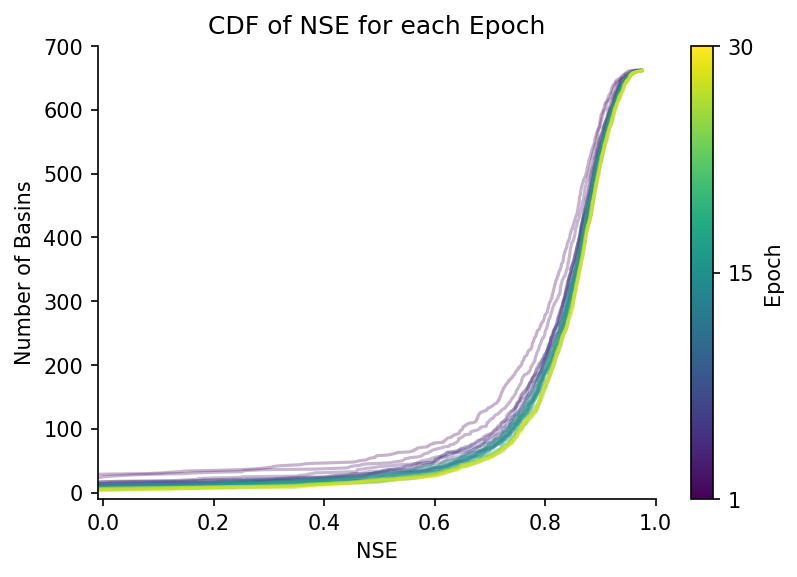

In [341]:
fig, ax = plt.subplots()
cmap = mpl.cm.get_cmap('viridis')
cm = plt.cm.ScalarMappable(cmap=cmap)
colors = [cmap(i) for i in np.linspace(0, 1, 30)]

for ix, epoch_nse in enumerate(epoch_nses):
    nse_col = [c for c in epoch_nse.columns if 'nse' in c][0]

    ax.plot(epoch_nse[nse_col], epoch_nse.index, color=colors[ix], alpha=0.3)
    ax.set_ylim(-10, 700)
    ax.set_xlim(-0.01, 1)
    sns.despine()

cbar = fig.colorbar(cm, ticks=[0, 0.5, 1.0])
cbar.ax.set_yticklabels([1, 15, 30])
cbar.ax.set_ylabel("Epoch")
ax.set_xlabel("NSE")
ax.set_ylabel("Number of Basins")
ax.set_title("CDF of NSE for each Epoch");

# Plot NSE over time

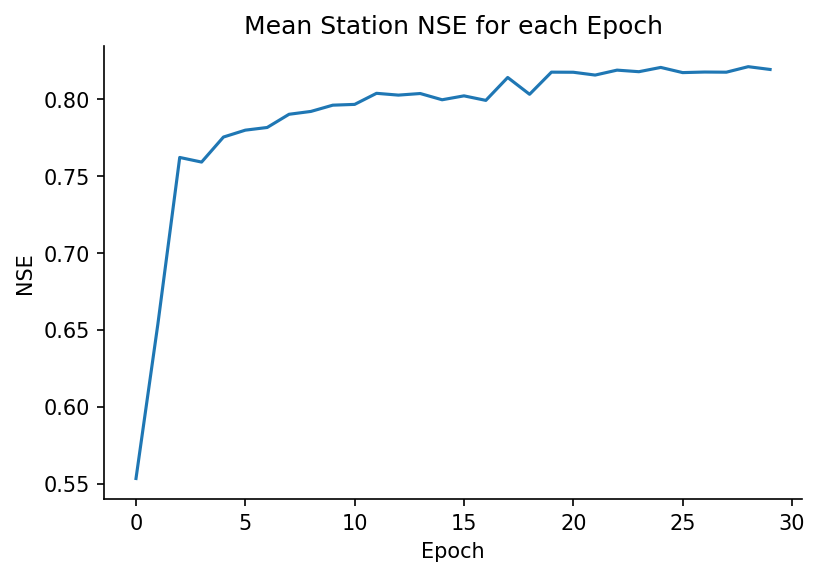

In [356]:
fig, ax = plt.subplots()
ax.plot(epoch_errors[[c for c in epoch_errors.columns if 'nse' in c]].mean().reset_index().drop('index', axis=1))
ax.set_title("Mean Station NSE for each Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("NSE")
sns.despine()

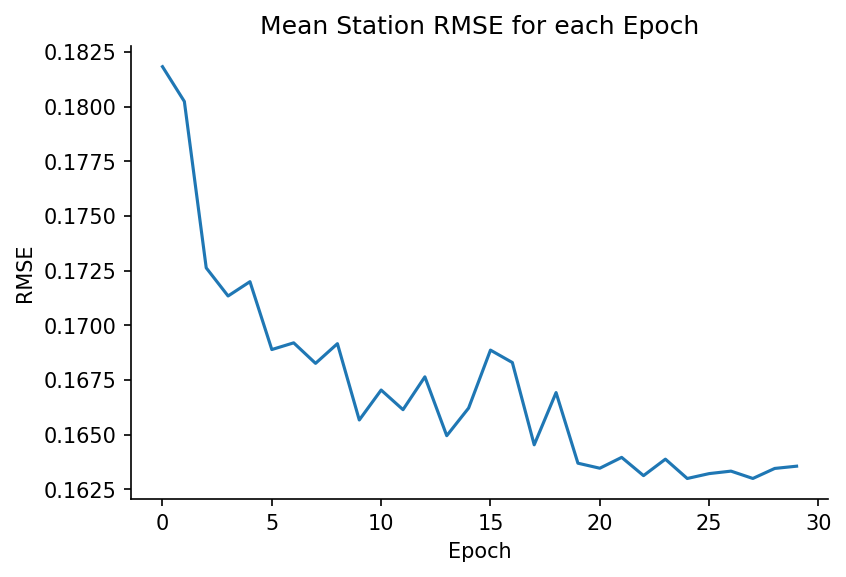

In [357]:
fig, ax = plt.subplots()
ax.plot(epoch_errors[[c for c in epoch_errors.columns if 'rmse' in c]].mean().reset_index().drop('index', axis=1))
ax.set_title("Mean Station RMSE for each Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("RMSE")
sns.despine()

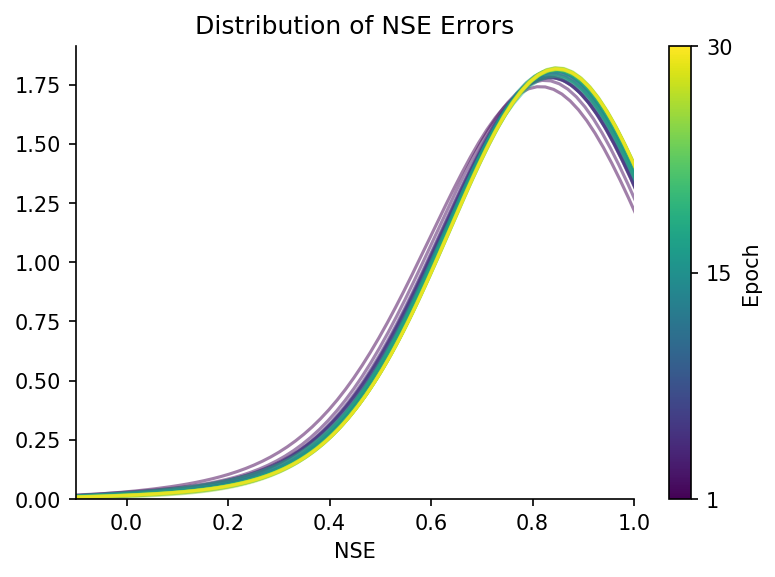

In [378]:
fig, ax = plt.subplots()
cmap = mpl.cm.get_cmap('viridis')
cm = plt.cm.ScalarMappable(cmap=cmap)
colors = [list(cmap(i)) for i in np.linspace(0, 1, 30)]

for ix, c in enumerate([c for c in epoch_errors.columns if 'nse' in c]):
    color = colors[ix]
    color[-1] = 0.5
    sns.kdeplot(epoch_errors[c], color=color, ax=ax, legend=False, bw=0.2, clip=(0, 1))

ax.set_xlim([-0.1, 1])
ax.set_xlabel('NSE')
cbar = fig.colorbar(cm, ticks=[0, 0.5, 1.0])
cbar.ax.set_yticklabels([1, 15, 30])
cbar.ax.set_ylabel("Epoch")

ax.set_title("Distribution of NSE Errors")
sns.despine()

# 13 catchments

In [ ]:
catchment_ids = [int(c) for c in ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]]
catchment_names = ["Dee@Park", "Tay@Ballathie", "Ouse@Skelton", "Ure@Kilgram", "Derwent@Buttercrambe", "Thames@Kingston", "Ock@Abingdon", "Avon@Knapp", "Tamar@Gunnislake", "Severn@Bewdley", "Severn@Haw", "Ribble@Samlesbury", "Clyde@Daldowie"]
station_map = dict(zip(catchment_ids, catchment_names))

In [ ]:
epoch_13 = epoch_errors.loc[np.isin(epoch_errors["station_id"], catchment_ids)]
epoch_13["catchment_name"] = catchment_names

In [ ]:
epoch_13.set_index('station_id')